loading annotations into memory...
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Done (t=3.26s)
creating index...
index created!
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid rang

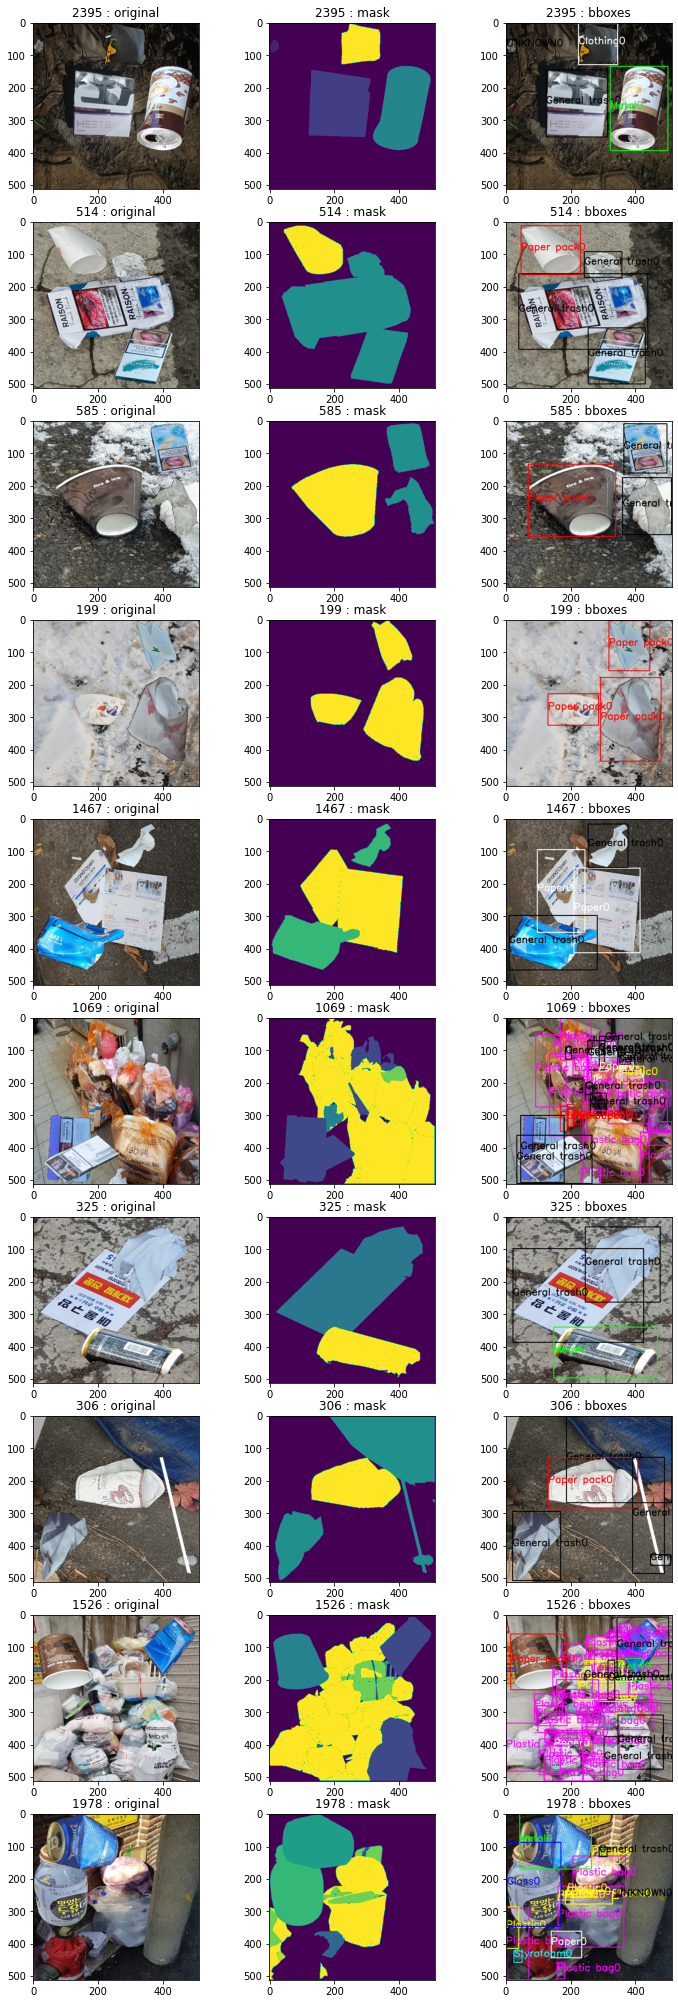

In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
import cv2


colors = [0,(0,0,0),(255,255,255), (255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255), (255,0,255), (192,192,192), (128,128,128), (128,0,0)]


labels = ("UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

def get_all_mask(img_id):
    image_info = coco.loadImgs(img_id)[0]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((image_info["height"], image_info["width"]))

    for ann in anns:
        cat = ann['category_id'] + 1
        _mask = coco.annToMask(ann)
        mask = np.where(_mask == 0, mask, cat)
#         mask = np.maximum(coco.annToMask(ann)*cat, mask)
    mask = mask.astype(np.uint8)
    return mask


def _draw_rectangle(image, label, score, y, x, height, width):
    cv2.rectangle(image, (y, x), (y+height, x+width), colors[label], 2)
    cv2.putText(image, f'{labels[label]}{score}', (y, x+width//2), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, colors[label], 2)
    return image


def draw_rectangle(image, anns):
    # bboxes = sorted(bboxes, key=lambda x:x[2], reverse=True)[:10]
    for ann in anns:
        label = ann['category_id']
        score = 0
        y, x, height, width = map(int, ann['bbox'])
        image = _draw_rectangle(image, label, score, y, x, height, width)
    
    return image


def get_bbox(PredictionString):
    bboxes = []
    PredictionString = PredictionString.split()
    for i in range(0, len(PredictionString), 6):
        label, score, y, x, height, width =  map(float, PredictionString[i:i+6])
        y = int(y)
        x = int(x)
        height = int(height)
        width = int(width)
        label = int(label)
        bboxes.append((label, score, y, x, height, width))
    return bboxes


def load_image(image_dir):
    image = cv2.imread(image_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64)
    return image/255


def show_image(images, row=3, col=2):
    fig = plt.figure(figsize=(12, 18))

    idx = 1

    for r in range(1, row+1):
        for c in range(1, col+1):
            image, image_id = images[r*row+c]
            ax = fig.add_subplot(row,col,idx)
            ax.imshow(image)
            ax.set_title(image_id)
            idx += 1
    plt.show()
    

def gen_img(coco, base_dir='data', n=10):
    fig = plt.figure(figsize=(12, 36))
    
    img_ids = [value['id'] for _, value in coco.imgs.items()]
    random.shuffle(img_ids)
    
    for idx, img_id in enumerate(img_ids[:n]):
        image_info = coco.loadImgs(img_id)[0]
        image = load_image(os.path.join(base_dir, image_info['file_name']))
        mask = get_all_mask(img_id)
        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        ax = fig.add_subplot(n,3,3*idx+1)
        ax.imshow(image)
        ax.set_title(f'{img_id} : original')
        
        ax = fig.add_subplot(n,3,3*idx+2)
        ax.imshow(mask)
        ax.set_title(f'{img_id} : mask')
        
        ax = fig.add_subplot(n,3,3*idx+3)
        ax.imshow(draw_rectangle(image, anns))
        ax.set_title(f'{img_id} : bboxes')
    plt.show()


coco_dir = 'data/train.json'
image_dir = 'data'
NumOfImg = 10
coco = COCO(coco_dir)
gen_img(coco, image_dir, NumOfImg)